In [1]:
import os,sys
import numpy as np
import scipy as sp
import pandas as pd
import tensorflow as tf 
import matplotlib as mlt
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation
sys.path.append("../src")  # adjust path as needed
from data_generator import data_generator
from model import pinn_models
from tensorflow.keras import models

### Load the data for ML model

In [2]:
data_dir = '/Users/pushpita/Documents/ML Projects/Project3/data/csv_files/diffusion0.1/'
D = 0.1

model_ini = pinn_models(data_dir, resolution=100, N_IC=100, N_BC=100, N_CP=100, epoch=3000)
model = model_ini.build_pinnmodel()
model_ini.train_model(diff_const=D)


Epoch 0: Total Loss = 9.7635e-01 | IC = 5.6201e-01 | BC = 8.9486e-02 | PDE = 3.2485e-01
Epoch 100: Total Loss = 1.0918e-01 | IC = 6.4692e-02 | BC = 2.1510e-02 | PDE = 2.2983e-02
Epoch 200: Total Loss = 1.9428e-02 | IC = 6.9559e-03 | BC = 2.4488e-03 | PDE = 1.0023e-02
Epoch 300: Total Loss = 2.5103e-03 | IC = 6.3669e-04 | BC = 4.1063e-04 | PDE = 1.4630e-03
Epoch 400: Total Loss = 1.2414e-03 | IC = 3.8252e-04 | BC = 4.4441e-04 | PDE = 4.1448e-04
Epoch 500: Total Loss = 1.0903e-03 | IC = 3.0971e-04 | BC = 3.7057e-04 | PDE = 4.1000e-04
Epoch 600: Total Loss = 8.9571e-04 | IC = 2.5724e-04 | BC = 3.6812e-04 | PDE = 2.7035e-04
Epoch 700: Total Loss = 7.8678e-04 | IC = 1.8726e-04 | BC = 2.7687e-04 | PDE = 3.2265e-04
Epoch 800: Total Loss = 5.6694e-04 | IC = 1.8205e-04 | BC = 2.6728e-04 | PDE = 1.1760e-04
Epoch 900: Total Loss = 6.3138e-04 | IC = 1.3495e-04 | BC = 2.4085e-04 | PDE = 2.5559e-04
Epoch 1000: Total Loss = 7.3566e-04 | IC = 1.7689e-04 | BC = 3.5947e-04 | PDE = 1.9930e-04
Epoch 1100:

In [3]:
files = sorted([f for f in os.listdir(data_dir) if f.startswith('data_') and f.endswith('.csv')])
nt = len(files) - 1 #Ignoring the initial condition
time_array = np.zeros((nt))
x_array = []
for i, file in enumerate(files[1:]):
    data_all = pd.read_csv(os.path.join(data_dir, file))
    if i == 1:
        x_array.append(data_all["x"])
        x = np.array(x_array)
    time_array[i] = data_all["t"].iloc[0]

ut = model_ini.predict(x, time_array)

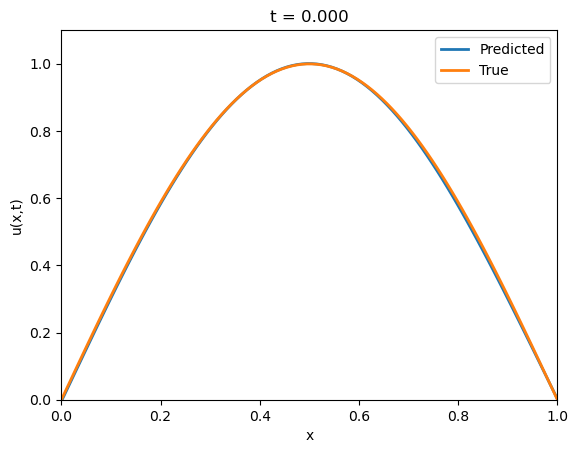

In [7]:
from matplotlib.animation import FuncAnimation

files = sorted([f for f in os.listdir(data_dir) if f.startswith('data_') and f.endswith('.csv')])
nt = len(files) - 1 #Ignoring the initial condition
time_array = np.zeros((nt))
ut_sol =[]
x_array = []
for i, file in enumerate(files[1:]):
    data_all = pd.read_csv(os.path.join(data_dir, file))
    ut_sol.append(data_all.filter(like='u_t').values.flatten())

# Prepare figure
fig, ax = plt.subplots()
line_pred, = ax.plot([], [], lw=2, label='Predicted')
line_true, = ax.plot([], [], lw=2, linestyle='-', label='True')
ax.set_xlim(x.min(), x.max())
ax.set_ylim(0, 1.1)  # Adjust based on your data
ax.set_xlabel("x")
ax.set_ylabel("u(x,t)")
title = ax.set_title("")
ax.legend()

# Animation update function
def update(frame):
    t_val = time_array[frame]
    x_input = np.copy(x)
    t_input = np.full_like(x_input, fill_value=t_val)
    
    u_pred = model_ini.predict(x_input, t_input).numpy().flatten()
    u_true = ut_sol[frame]

    line_pred.set_data(x_input, u_pred)
    line_true.set_data(x_input, u_true)
    title.set_text(f"t = {t_val:.3f}")
    return line_pred, line_true, title

# Create animation
anim = FuncAnimation(fig, update, frames=nt, interval=100, blit=True)
plt.show()
anim.save("pinn_heat_animation.mp4", writer='ffmpeg', fps=10)

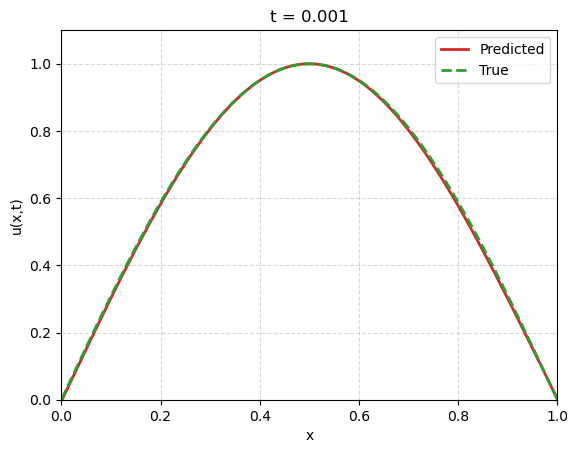

In [9]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

# Load all files
files = sorted([f for f in os.listdir(data_dir) if f.startswith('data_') and f.endswith('.csv')])
nt = len(files) - 1  # ignoring IC file
x = pd.read_csv(os.path.join(data_dir, files[1]))["x"].values  # x same for all
time_array = np.zeros((nt,))
true_solutions = []

for i, file in enumerate(files[1:]):
    df = pd.read_csv(os.path.join(data_dir, file))
    time_array[i] = df["t"].iloc[0]
    u_true = df.filter(like='u_t').values.flatten()  # all u_tX
    true_solutions.append(u_true)

true_solutions = np.array(true_solutions)  # shape: (nt, len(x))

# Prepare figure
fig, ax = plt.subplots()
line_pred, = ax.plot([], [], lw=2, color='tab:red', label='Predicted')
line_true, = ax.plot([], [], lw=2, color='tab:green', linestyle='--', label='True')
ax.set_xlim(x.min(), x.max())
ax.set_ylim(0, 1.1)  # adjust based on your data
ax.set_xlabel("x")
ax.set_ylabel("u(x,t)")
title = ax.set_title("")
ax.grid(linestyle='--',alpha=0.5)
ax.legend()

# Update function
def update(frame):
    t_val = time_array[frame]
    t_input = np.full_like(x, fill_value=t_val)
    
    u_pred = model_ini.predict(x, t_input).numpy().flatten()
    u_true = true_solutions[frame]

    line_pred.set_data(x, u_pred)
    line_true.set_data(x, u_true)
    title.set_text(f"t = {t_val:.3f}")
    return line_pred, line_true, title

# Animate
anim = FuncAnimation(fig, update, frames=nt, interval=100, blit=True)
plt.show()
anim.save("pinn_heat_animation.mp4", writer='ffmpeg', fps=10)

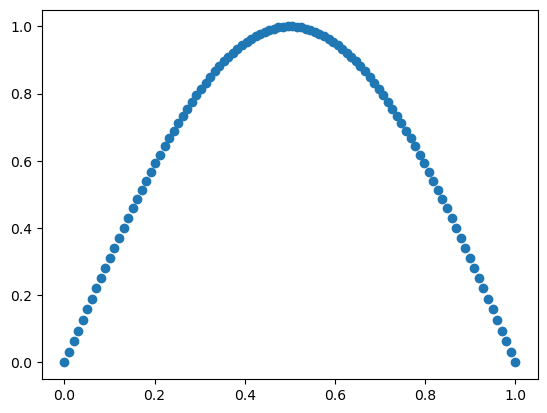

In [ ]:
data = pd.read_csv(data_dir+'data_0000.csv')
x = data['x']
u_xt = data['u_t0']
idx = np.random.choice(len(x), size=100, replace=False)
x_ic = x[idx]
t_ic = np.zeros_like(x_ic)
u_xt_ic = u_xt[idx]
x_tf_ic = tf.convert_to_tensor(x_ic, dtype=tf.float32)
t_tf_ic = tf.convert_to_tensor(t_ic, dtype=tf.float32)
u_tf_ic = tf.convert_to_tensor(u_xt_ic, dtype=tf.float32)
# X_input = tf.concat([x_tf_ic, t_tf_ic], axis=1)
X_input = tf.concat([x_tf_ic[:, None], t_tf_ic[:, None]], axis=1)
plt.plot(X_input[:,0], u_tf_ic,'o')